In [1]:

!pip install tqdm
!pip install torchinfo
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm 
from sklearn.metrics import accuracy_score, classification_report

import torch
import torch.nn.functional as F
from torch.utils import data
from torchinfo import summary
import torch.nn as nn
import torch.optim as optim
import json
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from datetime import datetime

# import json
# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import StandardScaler
# from datetime import datetime

# === File paths ===
snapshot_file = '../../datasets/Cong/BTCUSDT_orderbook_snapshot_2024_04_16-556.json'
trade_file = '../../datasets/Cong/BTCUSDT_trade_2024_04_16-886.json'

# === Load snapshot data ===
with open(snapshot_file, "r") as f:
    lines = f.readlines()
parsed_data = [json.loads(line) for line in lines]

snapshots = []
for entry in parsed_data:
    snapshots.append({
        "lastUpdateId": entry["lastUpdateId"],
        "asks": entry.get("asks", []),
        "bids": entry.get("bids", []),
        "timestamp": entry.get("record_utc_time")  # Optional: if available
    })

# === Load trade data ===
with open(trade_file, "r") as f:
    trade_lines = f.readlines()
trade_data = [json.loads(line) for line in trade_lines]
trade_records = [{"U": t["U"], "u": t["u"], "a": t["a"], "b": t["b"]} for t in trade_data]

# === Match snapshots to trades and attach trade_price ===
matched = []
for snap in tqdm(snapshots):
    snap_id = snap["lastUpdateId"]
    for t in trade_records:
        if t["U"] <= snap_id <= t["u"]:
            try:
                best_ask = float(t["a"][0][0])
                best_bid = float(t["b"][0][0])
                trade_price = (best_ask + best_bid) / 2
            except Exception:
                continue
            snap["trade_price"] = trade_price
            matched.append(snap)
            break

# === Feature engineering using snapshots ===
records = []
for snap in matched:
    row = {"timestamp": snap.get("timestamp")}
    asks = sorted([[float(p), float(v)] for p, v in snap["asks"]], key=lambda x: x[0])
    bids = sorted([[float(p), float(v)] for p, v in snap["bids"]], key=lambda x: -x[0])

    for i in range(10):
        row[f'ask_price_{i+1}'] = asks[i][0] if i < len(asks) else None
        row[f'ask_volume_{i+1}'] = asks[i][1] if i < len(asks) else None
        row[f'bid_price_{i+1}'] = bids[i][0] if i < len(bids) else None
        row[f'bid_volume_{i+1}'] = bids[i][1] if i < len(bids) else None

    row["mid_price"] = (row["ask_price_1"] + row["bid_price_1"]) / 2
    # row["spread"] = row["ask_price_1"] - row["bid_price_1"]
    # row["ask_depth"] = sum([row[f'ask_volume_{j+1}'] for j in range(10) if row[f'ask_volume_{j+1}'] is not None])
    # row["bid_depth"] = sum([row[f'bid_volume_{j+1}'] for j in range(10) if row[f'bid_volume_{j+1}'] is not None])
    # row["imbalance_5"] = (
    #     sum([row[f'bid_volume_{j+1}'] for j in range(5)]) -
    #     sum([row[f'ask_volume_{j+1}'] for j in range(5)])
    # ) / (
    #     sum([row[f'bid_volume_{j+1}'] for j in range(5)]) +
    #     sum([row[f'ask_volume_{j+1}'] for j in range(5)]) + 1e-8
    # )
    # row["imbalance_10"] = (
    #     sum([row[f'bid_volume_{j+1}'] for j in range(10)]) -
    #     sum([row[f'ask_volume_{j+1}'] for j in range(10)])
    # ) / (
    #     sum([row[f'bid_volume_{j+1}'] for j in range(10)]) +
    #     sum([row[f'ask_volume_{j+1}'] for j in range(10)]) + 1e-8
    # )
    row["trade_price"] = snap["trade_price"]
    records.append(row)

df = pd.DataFrame(records)
df = df.dropna(subset=["ask_price_1", "bid_price_1", "trade_price"]).reset_index(drop=True)

# === Normalize features ===
price_volume_cols = [col for col in df.columns if col.startswith(('ask_', 'bid_'))]
scaler = StandardScaler()
df_norm = pd.DataFrame(scaler.fit_transform(df[price_volume_cols]), columns=price_volume_cols)
df_norm["trade_price"] = df["trade_price"]
df_norm["mid_price_raw"] = df["mid_price"]
df_norm["timestamp"] = pd.to_datetime(df["timestamp"]) if "timestamp" in df else pd.NaT

# === Step-based labeling using trade price ===
step_horizons = [5, 10, 20, 30, 50]
epsilon = 0.0001
usable_df = df_norm.iloc[:-max(step_horizons)].copy()

def label_movement(p_now, p_future):
    delta = (p_future - p_now) / p_now
    if delta > epsilon:
        return 1
    elif delta < -epsilon:
        return 3
    else:
        return 2

for h in step_horizons:
    future_price = df_norm["trade_price"].shift(-h)
    usable_df[f"label_{h}"] = [
        label_movement(p, f) if pd.notna(f) else np.nan
        for p, f in zip(usable_df["trade_price"], future_price)
    ]

label_cols = [f"label_{h}" for h in step_horizons]
final_df = usable_df.dropna(subset=label_cols).reset_index(drop=True)

# # === Coin Context Vector ===
# df['log_return'] = np.log(df['mid_price']).diff()
# coin_context = {
#     "tick_size": 0.01,
#     "spread_median": df['spread'].median(),
#     "spread_std": df['spread'].std(),
#     "ask_depth_mean": df['ask_depth'].mean(),
#     "ask_depth_std": df['ask_depth'].std(),
#     "bid_depth_mean": df['bid_depth'].mean(),
#     "bid_depth_std": df['bid_depth'].std(),
#     "imbalance_5_mean": df['imbalance_5'].mean(),
#     "imbalance_5_std": df['imbalance_5'].std(),
# }

# for h in step_horizons:
#     coin_context[f"realized_vol_{h}"] = df['log_return'].rolling(window=h).std().mean()
#     coin_context[f"price_range_{h}"] = (df['mid_price'].rolling(window=h).max() - df['mid_price'].rolling(window=h).min()).mean()

# coin_context_df = pd.DataFrame([coin_context])
# context_scaler = StandardScaler()
# context_numeric = coin_context_df.select_dtypes(include=[np.number])
# context_normalized = pd.DataFrame(
#     context_scaler.fit_transform(context_numeric),
#     columns=context_numeric.columns
# )

# === Merge context with final_df ===
# context_broadcast = pd.concat([context_normalized] * len(final_df), ignore_index=True)
# context_broadcast.index = final_df.index
# final_df = pd.concat([final_df.drop(columns=label_cols), context_broadcast, final_df[label_cols]], axis=1)

final_df = final_df.drop(columns=["timestamp"])
final_df = final_df.drop(columns=["trade_price"])
final_df = final_df.drop(columns=["mid_price_raw"])


# === Done ===
# You can now use final_df for training
# final_df.to_csv("snapshot_trade_labeled_with_context.csv", index=False)





# # === Load JSON snapshot data ===
# json_path = '../../datasets/Cong/BTCUSDT_orderbook_snapshot_2024_04_16-556.json'
# with open(json_path, "r") as f:
#     lines = f.readlines()

# parsed_data = [json.loads(line) for line in lines]
# snapshots = []
# for entry in parsed_data:
#     snapshots.append({
#         "timestamp": entry.get("record_utc_time"),
#         "asks": entry.get("asks", []),
#         "bids": entry.get("bids", [])
#     })

# # === Feature Engineering ===
# records = []
# for snap in snapshots:
#     row = {"timestamp": snap["timestamp"]}
#     asks = sorted([[float(p), float(v)] for p, v in snap["asks"]], key=lambda x: x[0])
#     bids = sorted([[float(p), float(v)] for p, v in snap["bids"]], key=lambda x: -x[0])

#     for i in range(10):
#         row[f'ask_price_{i+1}'] = asks[i][0] if i < len(asks) else None
#         row[f'ask_volume_{i+1}'] = asks[i][1] if i < len(asks) else None
#         row[f'bid_price_{i+1}'] = bids[i][0] if i < len(bids) else None
#         row[f'bid_volume_{i+1}'] = bids[i][1] if i < len(bids) else None

#     row["mid_price"] = (row["ask_price_1"] + row["bid_price_1"]) / 2
#     row["spread"] = row["ask_price_1"] - row["bid_price_1"]
#     row["ask_depth"] = sum([row[f'ask_volume_{j+1}'] for j in range(10) if row[f'ask_volume_{j+1}'] is not None])
#     row["bid_depth"] = sum([row[f'bid_volume_{j+1}'] for j in range(10) if row[f'bid_volume_{j+1}'] is not None])
#     row["imbalance_5"] = (
#         sum([row[f'bid_volume_{j+1}'] for j in range(5)]) -
#         sum([row[f'ask_volume_{j+1}'] for j in range(5)])
#     ) / (
#         sum([row[f'bid_volume_{j+1}'] for j in range(5)]) +
#         sum([row[f'ask_volume_{j+1}'] for j in range(5)]) + 1e-8
#     )
#     row["imbalance_10"] = (
#         sum([row[f'bid_volume_{j+1}'] for j in range(10)]) -
#         sum([row[f'ask_volume_{j+1}'] for j in range(10)])
#     ) / (
#         sum([row[f'bid_volume_{j+1}'] for j in range(10)]) +
#         sum([row[f'ask_volume_{j+1}'] for j in range(10)]) + 1e-8
#     )
#     records.append(row)

# df = pd.DataFrame(records)
# df = df.dropna(subset=["ask_price_1", "bid_price_1"]).reset_index(drop=True)
# df["timestamp"] = pd.to_datetime(df["timestamp"])

# # === Normalize numerical features ===
# price_volume_cols = [col for col in df.columns if col.startswith(('ask_', 'bid_')) or col in [
#     "mid_price", "spread", "ask_depth", "bid_depth", "imbalance_5", "imbalance_10"
# ]]
# scaler = StandardScaler()
# df_norm = pd.DataFrame(scaler.fit_transform(df[price_volume_cols]), columns=price_volume_cols)
# df_norm["timestamp"] = df["timestamp"]
# df_norm["mid_price_raw"] = df["mid_price"]

# # === Step-based Labeling ===
# step_horizons = [5, 10, 20, 30, 50]
# epsilon = 0.0001

# def label_movement(p_now, p_future):
#     delta = (p_future - p_now) / p_now
#     if delta > epsilon:
#         return 1
#     elif delta < -epsilon:
#         return 3
#     else:
#         return 2

# usable_df = df_norm.iloc[:-max(step_horizons)].copy()
# for h in step_horizons:
#     future_mid = df_norm["mid_price_raw"].shift(-h)
#     usable_df[f"label_{h}"] = [
#         label_movement(p, f) if pd.notna(f) else np.nan
#         for p, f in zip(usable_df["mid_price_raw"], future_mid)
#     ]
# label_cols = [f"label_{h}" for h in step_horizons]
# final_df = usable_df.dropna(subset=label_cols).reset_index(drop=True)

# # === Coin Context Vector ===
# df['log_return'] = np.log(df['mid_price']).diff()
# coin_context = {
#     "tick_size": 0.01,
#     # "exchange": "Binance",
#     "spread_median": df['spread'].median(),
#     "spread_std": df['spread'].std(),
#     "ask_depth_mean": df['ask_depth'].mean(),
#     "ask_depth_std": df['ask_depth'].std(),
#     "bid_depth_mean": df['bid_depth'].mean(),›
#     "bid_depth_std": df['bid_depth'].std(),
#     "imbalance_5_mean": df['imbalance_5'].mean(),
#     "imbalance_5_std": df['imbalance_5'].std(),
#     # "update_frequency_sec": df['timestamp'].diff().dt.total_seconds().dropna().mean(),
# }

# # Add volatility and price range for each horizon
# for h in step_horizons:
#     coin_context[f"realized_vol_{h}"] = df['log_return'].rolling(window=h).std().mean()
#     coin_context[f"price_range_{h}"] = (df['mid_price'].rolling(window=h).max() - df['mid_price'].rolling(window=h).min()).mean()

# coin_context_df = pd.DataFrame([coin_context])

# # === Normalize coin context vector ===
# # context_numeric = coin_context_df.drop(columns=["exchange"])
# context_scaler = StandardScaler()
# context_normalized = pd.DataFrame(context_scaler.fit_transform(context_numeric), columns=context_numeric.columns)
# # context_normalized["exchange"] = coin_context_df["exchange"].values  # Add back exchange (if needed for reference)

# # === Merge with final_df ===
# context_broadcast = pd.concat([context_normalized] * len(final_df), ignore_index=True)
# context_broadcast.index = final_df.index
# merged_df = pd.concat([final_df.drop(columns=label_cols), context_broadcast, final_df[label_cols]], axis=1)

# # Your final dataframe
# final_df = merged_df

# final_df = final_df.drop(columns=["timestamp"])


# # Load JSON snapshot data
# json_path = '../../datasets/Cong/BTCUSDT_orderbook_snapshot_2024_04_16-556.json'
# with open(json_path, "r") as f:
#     lines = f.readlines()

# parsed_data = [json.loads(line) for line in lines]
# snapshots = []
# for entry in parsed_data:
#     snapshots.append({
#         "timestamp": entry.get("record_utc_time"),
#         "asks": entry.get("asks", []),
#         "bids": entry.get("bids", [])
#     })

# records = []
# for snap in snapshots:
#     row = {"timestamp": snap["timestamp"]}
#     for i in range(10):
#         if i < len(snap["asks"]):
#             row[f'ask_price_{i+1}'] = float(snap["asks"][i][0])
#             row[f'ask_volume_{i+1}'] = float(snap["asks"][i][1])
#         else:
#             row[f'ask_price_{i+1}'] = None
#             row[f'ask_volume_{i+1}'] = None
#         if i < len(snap["bids"]):
#             row[f'bid_price_{i+1}'] = float(snap["bids"][i][0])
#             row[f'bid_volume_{i+1}'] = float(snap["bids"][i][1])
#         else:
#             row[f'bid_price_{i+1}'] = None
#             row[f'bid_volume_{i+1}'] = None
#     records.append(row)

# df = pd.DataFrame(records)
# df = df.dropna(subset=["ask_price_1", "bid_price_1"]).reset_index(drop=True)

# # Normalize features
# price_volume_cols = [col for col in df.columns if col.startswith('ask_price_') or 
#                      col.startswith('bid_price_') or col.startswith('ask_volume_') or 
#                      col.startswith('bid_volume_')]

# scaler = StandardScaler()
# df_norm = pd.DataFrame(scaler.fit_transform(df[price_volume_cols]), columns=price_volume_cols)
# df_norm["timestamp"] = pd.to_datetime(df["timestamp"])
# df_norm["mid_price"] = (df["ask_price_1"] + df["bid_price_1"]) / 2

# # Multi-horizon label generation
# horizons = [5, 10, 20, 30, 50]
# # horizons = [10, 20, 30, 50, 100]
# epsilon = 0.0001

# # Use 3-class labeling
# def label_movement(p_now, p_future):
#     delta = (p_future - p_now) / p_now
#     if delta > epsilon:
#         return 1  # Up
#     elif delta < -epsilon:
#         return 3  # Down
#     else:
#         return 2  # Stationary

# usable_df = df_norm.iloc[:-max(horizons)].copy()
# for h in horizons:
#     future_mid = df_norm["mid_price"].shift(-h)
#     usable_df[f"label_{h}"] = [
#         label_movement(p, f) if pd.notna(f) else np.nan
#         for p, f in zip(usable_df["mid_price"], future_mid)
#     ]

# label_cols = [f"label_{h}" for h in horizons]
# final_df = usable_df.dropna(subset=label_cols).reset_index(drop=True)
print("Processed dataset shape:", final_df.shape)


/Users/lydiali/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/lydiali/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/Users/lydiali/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
100%|███████████████████████| 1183/1183 [19:43<00:00,  1.00s/it]


Processed dataset shape: (1089, 45)


In [2]:
final_df = final_df.T

In [3]:
final_df

,0,1,2,3,4,5,6,7,8,9,...,1079,1080,1081,1082,1083,1084,1085,1086,1087,1088
ask_price_1,0.787777,0.758016,0.939000,0.793726,1.009654,0.764239,0.765947,0.691661,0.733535,0.778020,...,1.358018,1.361493,1.464755,1.399127,1.574732,1.473707,1.508063,1.498541,1.518134,1.556828
ask_volume_1,-0.889437,0.309400,0.260860,0.596678,-0.794347,-0.399067,0.278482,0.051446,-1.074707,-0.853522,...,-0.871834,1.339390,1.550618,2.036066,0.100610,-1.124067,0.054699,1.058963,1.625680,-0.937288
bid_price_1,0.787798,0.758037,0.939019,0.793746,1.009672,0.764260,0.765968,0.691683,0.733557,0.778041,...,1.358031,1.361505,1.464766,1.399139,1.574741,1.473718,1.508073,1.498552,1.518144,1.556838
bid_volume_1,0.369989,-0.802514,-0.789181,-0.867463,0.505927,-0.957800,-0.503068,-1.089764,0.068876,1.929023,...,0.765229,-0.769640,-0.715331,-0.693146,-0.452891,-0.307373,0.014105,-0.765127,-0.956201,1.235708
ask_price_2,0.787888,0.757887,0.938915,0.793877,1.009834,0.763758,0.765466,0.691189,0.733266,0.777541,...,1.359226,1.361327,1.464505,1.398750,1.574634,1.474931,1.507936,1.498159,1.518127,1.557788
ask_volume_2,-0.125636,-0.244460,-0.244460,-0.434931,-0.246263,-0.028807,-0.447361,-0.447361,-0.447361,-0.400926,...,-0.447361,0.058041,0.196378,-0.245426,-0.434931,-0.447361,0.057461,-0.087993,-0.245426,-0.245426
bid_price_2,0.788259,0.758442,0.938029,0.794147,1.009990,0.764017,0.765823,0.691919,0.734023,0.778052,...,1.358191,1.361724,1.465150,1.399530,1.574308,1.473806,1.508373,1.498932,1.518522,1.557034
bid_volume_2,-0.133476,-0.134059,0.074742,0.062083,-0.029738,-0.092298,-0.133178,-0.119246,-0.132025,-0.029546,...,-0.131514,-0.134059,-0.128592,-0.118570,-0.092497,-0.092497,0.042280,-0.092497,-0.092371,-0.119883
ask_price_3,0.787568,0.758251,0.938615,0.793774,1.009680,0.763297,0.765163,0.690837,0.734156,0.777396,...,1.359255,1.363712,1.464233,1.399314,1.574219,1.476094,1.507572,1.498814,1.519629,1.557587
ask_volume_3,-0.262882,0.275781,-0.506480,-0.451355,0.016680,-0.247772,1.895348,0.078651,-0.262882,0.911670,...,0.120005,-0.264062,-0.495738,-0.234827,-0.264062,-0.510808,-0.420074,-0.264062,-0.264062,-0.117337


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:
def prepare_x(data):
    df1 = data[:67, :].T
    return np.array(df1)

def get_label(data):
    lob = data[-5:, :].T
    return lob

def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)

    dY = np.array(Y)

    dataY = dY[T - 1:N]

    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]

    return dataX, dataY

def torch_data(x, y):
    x = torch.from_numpy(x)
    x = torch.unsqueeze(x, 1)
    y = torch.from_numpy(y)
    y = F.one_hot(y, num_classes=3)
    return x, y

In [6]:
class Dataset(data.Dataset):
    """Characterizes a dataset for PyTorch"""
    def __init__(self, data, k, num_classes, T):
        """Initialization""" 
        self.k = k
        self.num_classes = num_classes
        self.T = T
            
        x = prepare_x(data)
        y = get_label(data)
        x, y = data_classification(x, y, self.T)
        y = y[:,self.k] - 1
        self.length = len(x)

        x = torch.from_numpy(x)
        self.x = torch.unsqueeze(x, 1)
        self.y = torch.from_numpy(y.astype(np.int64))

    def __len__(self):
        """Denotes the total number of samples"""
        return self.length

    def __getitem__(self, index):
        """Generates samples of data"""
        return self.x[index], self.y[index]

Data preparation
We used no auction dataset that is normalised by decimal precision approach in their work. The first seven days are training data and the last three days are testing data. A validation set (20%) from the training set is used to monitor the overfitting behaviours.

The first 40 columns of the FI-2010 dataset are 10 levels ask and bid information for a limit order book and we only use these 40 features in our network. The last 5 columns of the FI-2010 dataset are the labels with different prediction horizons.

In [7]:
# please change the data_path to your local path
# data_path = '/nfs/home/zihaoz/limit_order_book/data'

# dec_data = np.loadtxt('../data/data/Train_Dst_NoAuction_DecPre_CF_7.txt')
# dec_train = dec_data[:, :int(np.floor(dec_data.shape[1] * 0.8))]
# dec_val = dec_data[:, int(np.floor(dec_data.shape[1] * 0.8)):]

# dec_test1 = np.loadtxt('../data/data/Test_Dst_NoAuction_DecPre_CF_7.txt')
# dec_test2 = np.loadtxt('../data/data/Test_Dst_NoAuction_DecPre_CF_8.txt')
# dec_test3 = np.loadtxt('../data/data/Test_Dst_NoAuction_DecPre_CF_9.txt')
# dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

# Split into training (80%), validation (10%), and test (10%) without shuffling (time series)
num_samples = len(final_df.T)
train_end = int(num_samples * 0.8)
val_end = int(num_samples * 0.9)
final_df_np = final_df.values

dec_train = final_df_np[:, :train_end]
dec_val = final_df_np[:, train_end:val_end]
dec_test = final_df_np[:, val_end:]

print(dec_train.shape, dec_val.shape, dec_test.shape)

(45, 871) (45, 109) (45, 109)


In [8]:
batch_size = 64

dataset_train = Dataset(data=dec_train, k=4, num_classes=3, T=50)
dataset_val = Dataset(data=dec_val, k=4, num_classes=3, T=50)
dataset_test = Dataset(data=dec_test, k=4, num_classes=3, T=50)

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

print(dataset_train.x.shape, dataset_train.y.shape)

torch.Size([822, 1, 50, 45]) torch.Size([822])


In [9]:
tmp_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=1, shuffle=True)

for x, y in tmp_loader:
    print(x)
    print(y)
    print(x.shape, y.shape)
    break

tensor([[[[-2.1014,  0.7856, -2.1014,  ...,  1.0000,  1.0000,  1.0000],
          [-2.2486, -0.7438, -2.2486,  ...,  1.0000,  1.0000,  1.0000],
          [-2.3499,  0.3212, -2.3498,  ...,  1.0000,  1.0000,  1.0000],
          ...,
          [-0.3261, -1.0457, -0.3260,  ...,  3.0000,  3.0000,  3.0000],
          [-0.7385, -1.1196, -0.7385,  ...,  3.0000,  1.0000,  1.0000],
          [-0.6338,  0.4428, -0.6338,  ...,  3.0000,  1.0000,  1.0000]]]],
       dtype=torch.float64)
tensor([0])
torch.Size([1, 1, 50, 45]) torch.Size([1])


Model Architecture
Please find the detailed discussion of our model architecture in our paper.

In [22]:
class deeplob(nn.Module):
    def __init__(self, y_len):
        super().__init__()
        self.y_len = y_len
        
        # convolution blocks
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.LeakyReLU(negative_slope=0.01),
#             nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,10)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        
        # inception moduels
        self.inp1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp3 = nn.Sequential(
            nn.MaxPool2d((3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        
        # lstm layers
        self.lstm = nn.LSTM(input_size=384, hidden_size=64, num_layers=1, batch_first=True)
        # self.lstm = nn.LSTM(input_size=192, hidden_size=64, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(64, self.y_len)

    def forward(self, x):
        batch_size = x.size(0)
    
        # Initial hidden and cell state for LSTM
        h0 = torch.zeros(1, batch_size, 64).to(x.device)
        c0 = torch.zeros(1, batch_size, 64).to(x.device)
    
        # Convolutional layers
        x = self.conv1(x)       # (B, C1, T, D)
        x = self.conv2(x)       # (B, C2, T, D)
        x = self.conv3(x)       # (B, C3, T, D)
    
        # Inception-like branches
        x_inp1 = self.inp1(x)   # e.g., 1x1 conv
        x_inp2 = self.inp2(x)   # e.g., 3x1 conv
        x_inp3 = self.inp3(x)   # e.g., 5x1 conv
    
        # Concatenate across the channel dimension
        x = torch.cat((x_inp1, x_inp2, x_inp3), dim=1)  # shape: (B, C_total, T, D)
    
        # Prepare input for LSTM
        x = x.permute(0, 2, 1, 3)                 # (B, T, C, D)
        x = x.reshape(batch_size, x.shape[1], -1) # (B, T, C*D)
    
        # LSTM expects input of shape (B, T, input_size)
        x, _ = self.lstm(x, (h0, c0))             # output: (B, T, hidden_size)
    
        # Use last time step's hidden state
        x = x[:, -1, :]                           # (B, hidden_size)
    
        # Fully connected + softmax for classification
        x = self.fc1(x)                           # (B, num_classes)
        forecast_y = torch.softmax(x, dim=1)
    
        return forecast_y


#     def forward(self, x):
#         # h0: (number of hidden layers, batch size, hidden size)
#         h0 = torch.zeros(1, x.size(0), 64).to(device)
#         c0 = torch.zeros(1, x.size(0), 64).to(device)
    
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.conv3(x)
        
#         x_inp1 = self.inp1(x)
#         x_inp2 = self.inp2(x)
#         x_inp3 = self.inp3(x)  
        
#         x = torch.cat((x_inp1, x_inp2, x_inp3), dim=1)
        
# #         x = torch.transpose(x, 1, 2)
#         x = x.permute(0, 2, 1, 3)
#         x = torch.reshape(x, (-1, x.shape[1], x.shape[2]))
        
#         x, _ = self.lstm(x, (h0, c0))
#         x = x[:, -1, :]
#         x = self.fc1(x)
#         forecast_y = torch.softmax(x, dim=1)
        
#         return forecast_y

In [23]:
model = deeplob(y_len = dataset_train.num_classes)
model.to(device)

deeplob(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(1, 2), stride=(1, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 2), stride=(1, 2))
    (1): Tanh()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (4): Tanh()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(4, 1), stride

In [24]:
# summary(model, (1, 1, 100, 66))

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Model Training

In [26]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    best_test_loss = np.inf
    best_test_epoch = 0

    for it in tqdm(range(epochs)):
        
        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            # move data to GPU
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)
            # print("inputs.shape:", inputs.shape)
            # zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass
            # print("about to get model output")
            outputs = model(inputs)
            # print("done getting model output")
            # print("outputs.shape:", outputs.shape, "targets.shape:", targets.shape)
            loss = criterion(outputs, targets)
            # Backward and optimize
            # print("about to optimize")
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        # Get train loss and test loss
        train_loss = np.mean(train_loss) # a little misleading
    
        model.eval()
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)      
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        
        if test_loss < best_test_loss:
            torch.save(model, './best_val_model_pytorch')
            best_test_loss = test_loss
            best_test_epoch = it
            print('model saved')

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
          Validation Loss: {test_loss:.4f}, Duration: {dt}, Best Val Epoch: {best_test_epoch}')

    return train_losses, test_losses

In [27]:
train_losses, val_losses = batch_gd(model, criterion, optimizer, 
                                    train_loader, val_loader, epochs=50)

  2%|▌                           | 1/50 [00:21<17:23, 21.29s/it]

model saved
Epoch 1/50, Train Loss: 1.0791,           Validation Loss: 1.0755, Duration: 0:00:21.286728, Best Val Epoch: 0


  4%|█                           | 2/50 [00:26<09:15, 11.58s/it]

model saved
Epoch 2/50, Train Loss: 1.0312,           Validation Loss: 1.0611, Duration: 0:00:04.777107, Best Val Epoch: 1


  6%|█▋                          | 3/50 [00:30<06:38,  8.47s/it]

model saved
Epoch 3/50, Train Loss: 0.9880,           Validation Loss: 1.0363, Duration: 0:00:04.779426, Best Val Epoch: 2


  8%|██▏                         | 4/50 [00:35<05:23,  7.04s/it]

model saved
Epoch 4/50, Train Loss: 0.9378,           Validation Loss: 1.0084, Duration: 0:00:04.849954, Best Val Epoch: 3


 10%|██▊                         | 5/50 [00:40<04:40,  6.24s/it]

model saved
Epoch 5/50, Train Loss: 0.8839,           Validation Loss: 0.9595, Duration: 0:00:04.813584, Best Val Epoch: 4


 12%|███▎                        | 6/50 [00:45<04:12,  5.74s/it]

model saved
Epoch 6/50, Train Loss: 0.8237,           Validation Loss: 0.9023, Duration: 0:00:04.763123, Best Val Epoch: 5


 14%|███▉                        | 7/50 [00:50<03:52,  5.41s/it]

model saved
Epoch 7/50, Train Loss: 0.7653,           Validation Loss: 0.8336, Duration: 0:00:04.748513, Best Val Epoch: 6


 16%|████▍                       | 8/50 [00:54<03:38,  5.21s/it]

model saved
Epoch 8/50, Train Loss: 0.7171,           Validation Loss: 0.7841, Duration: 0:00:04.768308, Best Val Epoch: 7


 18%|█████                       | 9/50 [00:59<03:27,  5.07s/it]

model saved
Epoch 9/50, Train Loss: 0.6800,           Validation Loss: 0.7360, Duration: 0:00:04.753124, Best Val Epoch: 8


 20%|█████▍                     | 10/50 [01:04<03:18,  4.96s/it]

model saved
Epoch 10/50, Train Loss: 0.6578,           Validation Loss: 0.7107, Duration: 0:00:04.733044, Best Val Epoch: 9


 22%|█████▉                     | 11/50 [01:09<03:11,  4.90s/it]

model saved
Epoch 11/50, Train Loss: 0.6397,           Validation Loss: 0.7044, Duration: 0:00:04.756163, Best Val Epoch: 10


 24%|██████▍                    | 12/50 [01:13<03:04,  4.87s/it]

model saved
Epoch 12/50, Train Loss: 0.6288,           Validation Loss: 0.6953, Duration: 0:00:04.783485, Best Val Epoch: 11


 26%|███████                    | 13/50 [01:18<02:59,  4.84s/it]

model saved
Epoch 13/50, Train Loss: 0.6213,           Validation Loss: 0.6870, Duration: 0:00:04.786971, Best Val Epoch: 12


 28%|███████▌                   | 14/50 [01:23<02:53,  4.82s/it]

model saved
Epoch 14/50, Train Loss: 0.6151,           Validation Loss: 0.6789, Duration: 0:00:04.758481, Best Val Epoch: 13


 30%|████████                   | 15/50 [01:28<02:48,  4.81s/it]

model saved
Epoch 15/50, Train Loss: 0.6101,           Validation Loss: 0.6753, Duration: 0:00:04.777814, Best Val Epoch: 14


 32%|████████▋                  | 16/50 [01:32<02:42,  4.79s/it]

model saved
Epoch 16/50, Train Loss: 0.6068,           Validation Loss: 0.6672, Duration: 0:00:04.760038, Best Val Epoch: 15


 34%|█████████▏                 | 17/50 [01:37<02:37,  4.78s/it]

Epoch 17/50, Train Loss: 0.6033,           Validation Loss: 0.6756, Duration: 0:00:04.755580, Best Val Epoch: 15


 36%|█████████▋                 | 18/50 [01:42<02:35,  4.85s/it]

Epoch 18/50, Train Loss: 0.5995,           Validation Loss: 0.6952, Duration: 0:00:04.994412, Best Val Epoch: 15


 38%|██████████▎                | 19/50 [01:47<02:29,  4.83s/it]

Epoch 19/50, Train Loss: 0.5967,           Validation Loss: 0.6718, Duration: 0:00:04.797317, Best Val Epoch: 15


 40%|██████████▊                | 20/50 [01:52<02:24,  4.82s/it]

model saved
Epoch 20/50, Train Loss: 0.5933,           Validation Loss: 0.6629, Duration: 0:00:04.781741, Best Val Epoch: 19


 42%|███████████▎               | 21/50 [01:56<02:19,  4.80s/it]

Epoch 21/50, Train Loss: 0.5935,           Validation Loss: 0.6641, Duration: 0:00:04.758417, Best Val Epoch: 19


 44%|███████████▉               | 22/50 [02:02<02:16,  4.88s/it]

model saved
Epoch 22/50, Train Loss: 0.5897,           Validation Loss: 0.6599, Duration: 0:00:05.073435, Best Val Epoch: 21


 46%|████████████▍              | 23/50 [02:06<02:11,  4.87s/it]

model saved
Epoch 23/50, Train Loss: 0.5916,           Validation Loss: 0.6591, Duration: 0:00:04.831543, Best Val Epoch: 22


 48%|████████████▉              | 24/50 [02:11<02:05,  4.84s/it]

Epoch 24/50, Train Loss: 0.5884,           Validation Loss: 0.6663, Duration: 0:00:04.786857, Best Val Epoch: 22


 50%|█████████████▌             | 25/50 [02:16<02:01,  4.86s/it]

model saved
Epoch 25/50, Train Loss: 0.5848,           Validation Loss: 0.6554, Duration: 0:00:04.892069, Best Val Epoch: 24


 52%|██████████████             | 26/50 [02:21<01:56,  4.84s/it]

Epoch 26/50, Train Loss: 0.5854,           Validation Loss: 0.6604, Duration: 0:00:04.786115, Best Val Epoch: 24


 54%|██████████████▌            | 27/50 [02:26<01:50,  4.82s/it]

model saved
Epoch 27/50, Train Loss: 0.5825,           Validation Loss: 0.6548, Duration: 0:00:04.776279, Best Val Epoch: 26


 56%|███████████████            | 28/50 [02:30<01:46,  4.82s/it]

Epoch 28/50, Train Loss: 0.5817,           Validation Loss: 0.6572, Duration: 0:00:04.817037, Best Val Epoch: 26


 58%|███████████████▋           | 29/50 [02:35<01:40,  4.81s/it]

Epoch 29/50, Train Loss: 0.5795,           Validation Loss: 0.6557, Duration: 0:00:04.779216, Best Val Epoch: 26


 60%|████████████████▏          | 30/50 [02:40<01:36,  4.80s/it]

Epoch 30/50, Train Loss: 0.5787,           Validation Loss: 0.6589, Duration: 0:00:04.788365, Best Val Epoch: 26


 62%|████████████████▋          | 31/50 [02:45<01:31,  4.80s/it]

Epoch 31/50, Train Loss: 0.5772,           Validation Loss: 0.6579, Duration: 0:00:04.780590, Best Val Epoch: 26


 64%|█████████████████▎         | 32/50 [02:52<01:39,  5.52s/it]

Epoch 32/50, Train Loss: 0.5769,           Validation Loss: 0.6564, Duration: 0:00:07.213916, Best Val Epoch: 26


 66%|█████████████████▊         | 33/50 [02:57<01:30,  5.31s/it]

model saved
Epoch 33/50, Train Loss: 0.5762,           Validation Loss: 0.6514, Duration: 0:00:04.830840, Best Val Epoch: 32


 68%|██████████████████▎        | 34/50 [03:02<01:22,  5.16s/it]

Epoch 34/50, Train Loss: 0.5754,           Validation Loss: 0.6617, Duration: 0:00:04.812031, Best Val Epoch: 32


 70%|██████████████████▉        | 35/50 [03:06<01:15,  5.05s/it]

Epoch 35/50, Train Loss: 0.5755,           Validation Loss: 0.6576, Duration: 0:00:04.778531, Best Val Epoch: 32


 72%|███████████████████▍       | 36/50 [03:11<01:09,  4.98s/it]

model saved
Epoch 36/50, Train Loss: 0.5750,           Validation Loss: 0.6484, Duration: 0:00:04.831960, Best Val Epoch: 35


 74%|███████████████████▉       | 37/50 [03:16<01:04,  4.93s/it]

model saved
Epoch 37/50, Train Loss: 0.5745,           Validation Loss: 0.6460, Duration: 0:00:04.815452, Best Val Epoch: 36


 76%|████████████████████▌      | 38/50 [03:21<00:58,  4.89s/it]

model saved
Epoch 38/50, Train Loss: 0.5742,           Validation Loss: 0.6445, Duration: 0:00:04.775559, Best Val Epoch: 37


 78%|█████████████████████      | 39/50 [03:26<00:53,  4.85s/it]

Epoch 39/50, Train Loss: 0.5733,           Validation Loss: 0.6464, Duration: 0:00:04.770332, Best Val Epoch: 37


 80%|█████████████████████▌     | 40/50 [03:30<00:48,  4.83s/it]

Epoch 40/50, Train Loss: 0.5734,           Validation Loss: 0.6507, Duration: 0:00:04.765375, Best Val Epoch: 37


 82%|██████████████████████▏    | 41/50 [03:35<00:43,  4.81s/it]

Epoch 41/50, Train Loss: 0.5724,           Validation Loss: 0.6600, Duration: 0:00:04.765444, Best Val Epoch: 37


 84%|██████████████████████▋    | 42/50 [03:40<00:38,  4.80s/it]

Epoch 42/50, Train Loss: 0.5722,           Validation Loss: 0.6708, Duration: 0:00:04.770450, Best Val Epoch: 37


 86%|███████████████████████▏   | 43/50 [03:45<00:33,  4.78s/it]

Epoch 43/50, Train Loss: 0.5718,           Validation Loss: 0.6624, Duration: 0:00:04.756090, Best Val Epoch: 37


 88%|███████████████████████▊   | 44/50 [03:49<00:28,  4.78s/it]

Epoch 44/50, Train Loss: 0.5713,           Validation Loss: 0.6689, Duration: 0:00:04.752590, Best Val Epoch: 37


 90%|████████████████████████▎  | 45/50 [03:54<00:23,  4.77s/it]

Epoch 45/50, Train Loss: 0.5708,           Validation Loss: 0.6755, Duration: 0:00:04.755038, Best Val Epoch: 37


 92%|████████████████████████▊  | 46/50 [03:59<00:19,  4.77s/it]

Epoch 46/50, Train Loss: 0.5705,           Validation Loss: 0.6640, Duration: 0:00:04.760185, Best Val Epoch: 37


 94%|█████████████████████████▍ | 47/50 [04:04<00:14,  4.76s/it]

Epoch 47/50, Train Loss: 0.5700,           Validation Loss: 0.6662, Duration: 0:00:04.755766, Best Val Epoch: 37


 96%|█████████████████████████▉ | 48/50 [04:08<00:09,  4.76s/it]

Epoch 48/50, Train Loss: 0.5703,           Validation Loss: 0.6666, Duration: 0:00:04.753533, Best Val Epoch: 37


 98%|██████████████████████████▍| 49/50 [04:13<00:04,  4.76s/it]

Epoch 49/50, Train Loss: 0.5693,           Validation Loss: 0.6697, Duration: 0:00:04.752305, Best Val Epoch: 37


100%|███████████████████████████| 50/50 [04:18<00:00,  5.17s/it]

Epoch 50/50, Train Loss: 0.5695,           Validation Loss: 0.6776, Duration: 0:00:04.747603, Best Val Epoch: 37


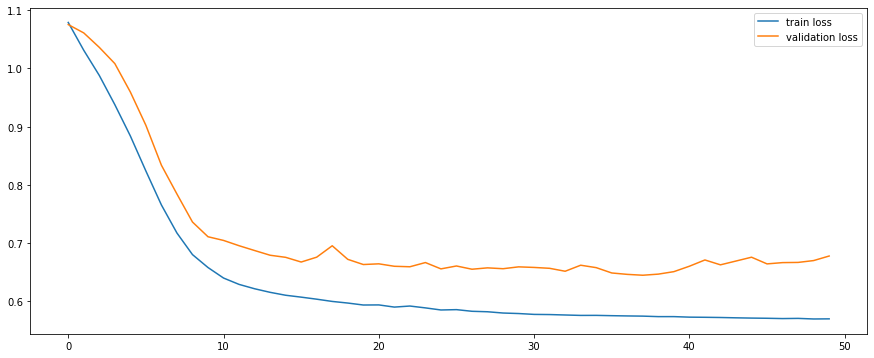

In [28]:
plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

Model Testing

In [29]:
model = torch.load('best_val_model_pytorch')

n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Test acc: {test_acc:.4f}")

Test acc: 0.6000


In [30]:
# model = torch.load('best_val_model_pytorch')
all_targets = []
all_predictions = []

for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions)    

In [31]:
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))

accuracy_score: 0.6
              precision    recall  f1-score   support

           0     0.5294    0.6923    0.6000        26
           1     0.0000    0.0000    0.0000         3
           2     0.6923    0.5806    0.6316        31

    accuracy                         0.6000        60
   macro avg     0.4072    0.4243    0.4105        60
weighted avg     0.5871    0.6000    0.5863        60



/Users/lydiali/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lydiali/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lydiali/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
